# APOGEE Example 1: Plotting a Keil Diagram for "Good" Measurements in DR17

In this example, we will:
- Load the AllStar file
- Select reliable measurements using simplistic criteria using bitmasks
- Remove duplicate targets using bitmasks
- Make a Keil diagram using (1) Calibrated and (2) Spectroscopic ASPCAP results
- Compare the Calibrated and Spectroscopic results for dwarfs and giants

In [1]:
import numpy as np
from astropy.io import fits 
#(or import pyfits as fits)
from matplotlib import pyplot as plt

## Load the AllStar File

The following blocks assumes that the the [Allstar file](https://sdss.org/dr17/irspec/spectro_data/) has been downloaded locally. Note that the Allstar file is ~4 Gb. Users should consult the [Allstar data model](https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html) to understand the data columns in the file. 

In DR17, the Allstar file has 733,901 entires. Note that each entry in the file refers to a target observed on a specific TELESCOPE, FIELD, and APOGEE_ID combination. Thus, if a star were observed in multiple fields, it would have multiple entries in the file. 

In [2]:
path_to_allstarfile = './allStar-dr17-synspec.fits'
star_hdus = fits.open(path_to_allstarfile)

# Refer to the data model to determine that the file has multiple HDUs and we only want the data array.
data = star_hdus[1].data
# Close the remaining HDUs
star_hdus.close()


## Selecting Reliable Data Using BitMasks


Like all SDSS data, [APOGEE uses Bitmasks](https://sdss.org/dr17/irspec/apogee-bitmasks/) to communicate data quality assessments. Because our goal is to make a Keil Diagram, we are most concerned with the bitmask associated with the [ASPCAP](https://sdss.org/dr17/irspec/aspcap/) results at the parameter level. This is caled the [APOGEE_ASPCAPFLAG](https://sdss.org/dr17/irspec/apogee-bitmasks/#APOGEE_ASPCAPFLAG:ASPCAPstarlevelbitmask) or [ASPCAPFLAG](https://sdss.org/dr17/irspec/apogee-bitmasks/#APOGEE_ASPCAPFLAG:ASPCAPstarlevelbitmask) in the Allstar file. APSCAPFLAG is a "star" level bitmask, meaning it is applied to an individual entry in the Allstar file. 


For this example, we are going to remove stars with bit 23, STAR_BAD, from consideration. This flag is set when the ASPCAP team has determined the results are likely to be poor (or BAD) -- e.g., if any of the "BAD" criteria for TEFF, LOGG, CHI2, COLORTE, ROTATION, SN error, or any GRIDEDGE_BAD. These are generic criteria to select the measurements most likely to be good.

We will also remove duplicate observations using [EXTRATARG](https://testng.sdss.org/dr17/irspec/apogee-bitmasks/#EXTRATARG:basictargetinginformation), which is a convenience bitmask. As discussed on [Using Targets/Samples](https://testng.sdss.org/dr17/irspec/targettingbits/#EXTRATARG) -- If no elements of EXTRATARG are set, then the star is part of the Main Red Star Sample (e.g., no special targets) and, if the target has duplicate observations, the target with the highest signal-to-noise will have no bits set. 

In [3]:
# determine the integer value for the bit 23 in ASPCAPFLAG
badbits = 2**23
# select for ASPCAPFLAG bit 23 not being set and for EXTRATARG to have no bits set
gd = (np.bitwise_and(data['aspcapflag'], badbits) == 0) & (data['extratarg']==0)
# 
ind = np.where(gd)[0]

In [4]:
teff_logg_check = np.logical_and(data["TEFF"] > 0, data["LOGG"] > -10) # this checks for -9999 values
teff_logg_feh_check = np.logical_and(data["FE_H"]> -6, teff_logg_check)

indices = np.where(np.logical_and(gd, teff_logg_feh_check)) 
good = data[indices] # this only the good data now

### Plotting the Calibrated Parameters

Text(0.5, 1.0, 'DR17 Calibrated Keil Diagram')

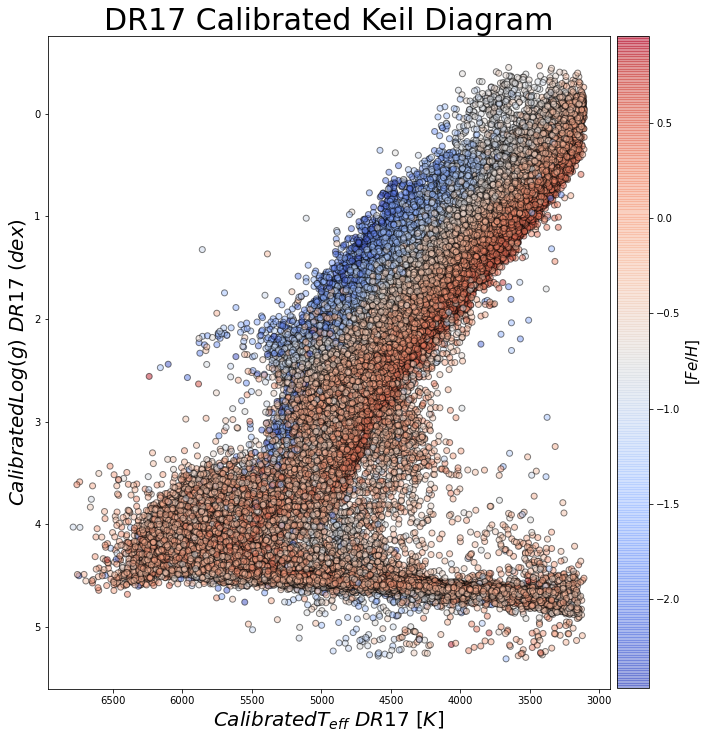

In [5]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

Teff_vals = good["TEFF"]
logg_vals = good["LOGG"]
FeH_vals  = good["FE_H"]

image = ax.scatter(Teff_vals,logg_vals, c=FeH_vals ,edgecolor='k',cmap="coolwarm",alpha=0.5)
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.set_label('$[Fe/H]$',size=15)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

ax.set_xlabel("$Calibrated T_{eff}~DR17$ $[K]$",size=20)
ax.set_ylabel("$Calibrated Log(g)~DR17$ $(dex)$",size=20)
ax.set_title("DR17 Calibrated Keil Diagram", size=30)
# Uncomment line below to save a copy of the figure
#plt.savefig("calibrated_hr.png")

### Plotting the Spectroscopic Parameters


Text(0.5, 1.0, 'DR17 Spectroscopic Keil Diagram')

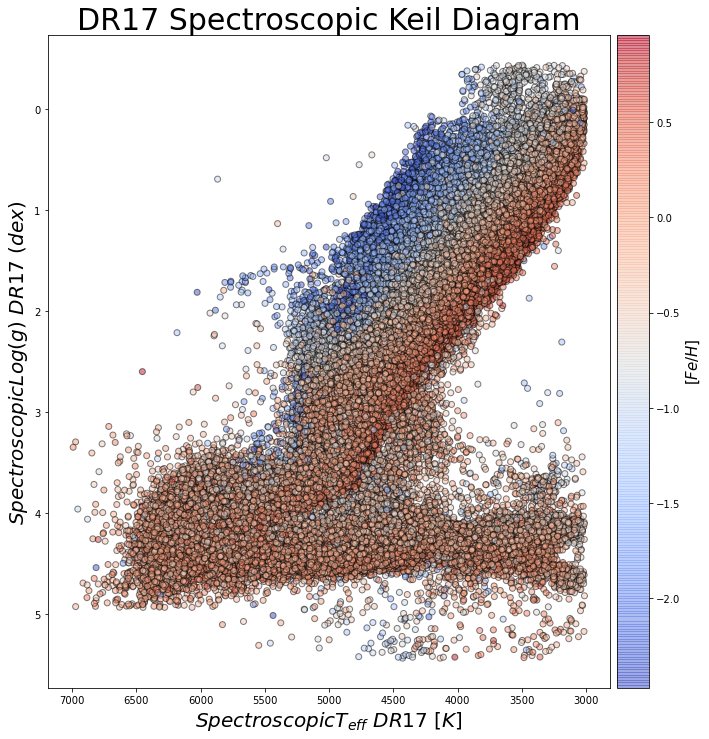

In [6]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

Teff_vals = good["TEFF_SPEC"]
logg_vals = good["LOGG_SPEC"]
FeH_vals = good["FE_H_SPEC"]

image = ax.scatter(Teff_vals,logg_vals, c=FeH_vals ,edgecolor='k',cmap="coolwarm",alpha=0.5)
bar = fig.colorbar(image,orientation="vertical",pad=0.01)
bar.set_label('$[Fe/H]$',size=15)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

ax.set_xlabel("$Spectroscopic T_{eff}~DR17$ $[K]$",size=20)
ax.set_ylabel("$Spectroscopic Log(g)~DR17$ $(dex)$",size=20)
ax.set_title("DR17 Spectroscopic Keil Diagram", size=30)
# Uncomment line below to save a copy of the figure
#plt.savefig("spectroscopic_hr.png")

### Comparing Spectroscopic and Calibrated Parameters

APOGEE calibrations are determined separately for dwarfs and giants.